<a href="https://colab.research.google.com/github/eadewusic/Formative-2_Data-Preprocessing/blob/main/Formative2_DataPreprocessing_Group18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Part 1: Data Augmentation on CSV Files

In [30]:
#import necessary package

import pandas as pd
from sklearn.impute import KNNImputer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from datetime import datetime
import warnings
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score

### Load the Dataset

In [ ]:
path = "/content/data/customer_transactions.csv"
df = pd.read_csv(path)

# Print some part of the dataset
df.head()

,customer_id_legacy,transaction_id,purchase_amount,purchase_date,product_category,customer_rating
0,151,1001,408,2024-01-01,Sports,2.3
1,192,1002,332,2024-01-02,Electronics,4.2
2,114,1003,442,2024-01-03,Electronics,2.1
3,171,1004,256,2024-01-04,Clothing,2.8
4,160,1005,64,2024-01-05,Clothing,1.3


### Data Cleaning & Handling Missing Values

In [ ]:
# Display basic info to check for missing data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id_legacy  150 non-null    int64  
 1   transaction_id      150 non-null    int64  
 2   purchase_amount     150 non-null    int64  
 3   purchase_date       150 non-null    object 
 4   product_category    150 non-null    object 
 5   customer_rating     140 non-null    float64
dtypes: float64(1), int64(3), object(2)
memory usage: 7.2+ KB


customer_rating column has 140 non-null values (meaning 10 missing values)

### Handle Missing Values

- Mean, Median, Mode Imputation

In [ ]:
df_mean = df.copy()  # make a copy to compare later
mean_value = df['customer_rating'].mean()

df_mean['customer_rating'] = df_mean['customer_rating'].fillna(mean_value)

# Verify that there are no more missing values
print("Missing values after Mean Imputation:", df_mean['customer_rating'].isnull().sum())

# View the first 5 rows
print(df_mean.head())

Missing values after Mean Imputation: 0
   customer_id_legacy  transaction_id  purchase_amount purchase_date  \
0                 151            1001              408    2024-01-01   
1                 192            1002              332    2024-01-02   
2                 114            1003              442    2024-01-03   
3                 171            1004              256    2024-01-04   
4                 160            1005               64    2024-01-05   

  product_category  customer_rating  
0           Sports              2.3  
1      Electronics              4.2  
2      Electronics              2.1  
3         Clothing              2.8  
4         Clothing              1.3  


In [ ]:
df_median = df.copy()
median_value = df['customer_rating'].median()

df_median['customer_rating'] = df_median['customer_rating'].fillna(median_value)

print("Missing values after Median Imputation:", df_median['customer_rating'].isnull().sum())
print(df_median.head())

Missing values after Median Imputation: 0
   customer_id_legacy  transaction_id  purchase_amount purchase_date  \
0                 151            1001              408    2024-01-01   
1                 192            1002              332    2024-01-02   
2                 114            1003              442    2024-01-03   
3                 171            1004              256    2024-01-04   
4                 160            1005               64    2024-01-05   

  product_category  customer_rating  
0           Sports              2.3  
1      Electronics              4.2  
2      Electronics              2.1  
3         Clothing              2.8  
4         Clothing              1.3  


In [ ]:
df_mode = df.copy()
mode_value = df['customer_rating'].mode()[0]  # mode() returns a Series, take the first mode

df_mode['customer_rating'] = df_mode['customer_rating'].fillna(mode_value)

print("Missing values after Mode Imputation:", df_mode['customer_rating'].isnull().sum())
print(df_mode.head())

Missing values after Mode Imputation: 0
   customer_id_legacy  transaction_id  purchase_amount purchase_date  \
0                 151            1001              408    2024-01-01   
1                 192            1002              332    2024-01-02   
2                 114            1003              442    2024-01-03   
3                 171            1004              256    2024-01-04   
4                 160            1005               64    2024-01-05   

  product_category  customer_rating  
0           Sports              2.3  
1      Electronics              4.2  
2      Electronics              2.1  
3         Clothing              2.8  
4         Clothing              1.3  


##Imputation Analysis & comparisons

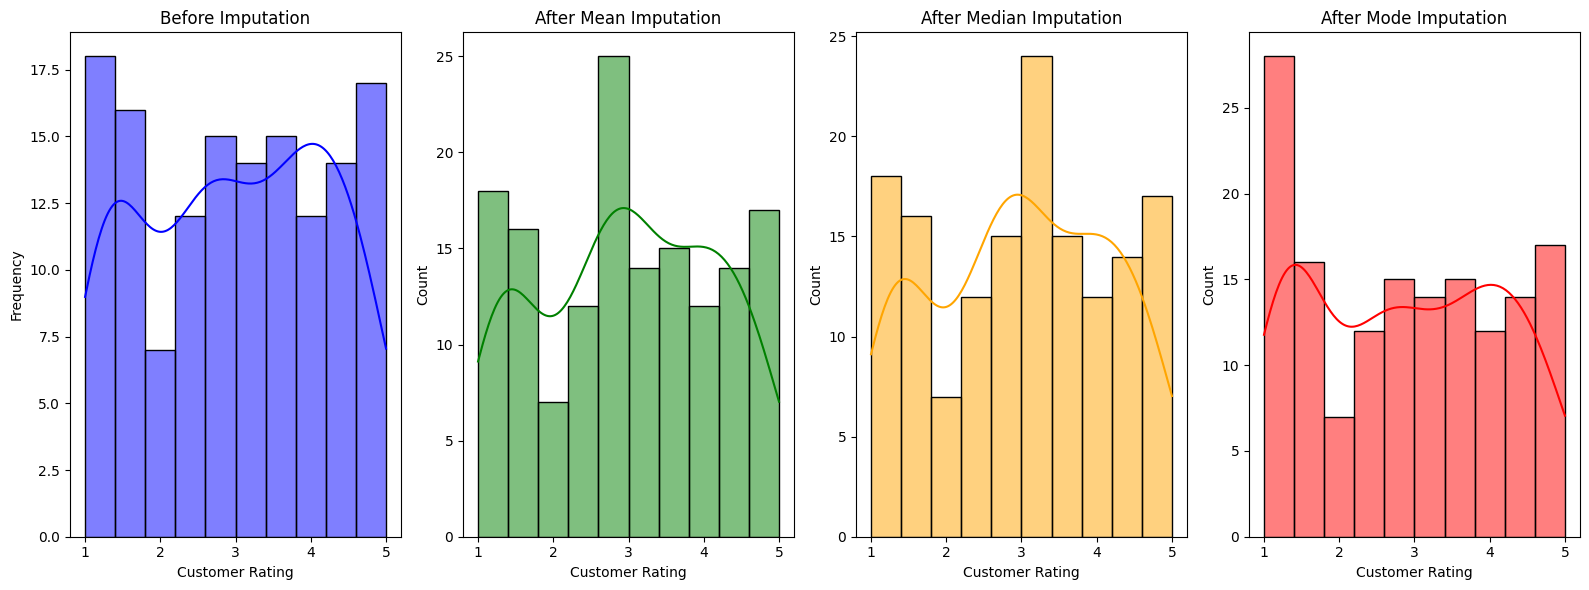

In [ ]:
plt.figure(figsize=(16, 6))

# Before Imputation
plt.subplot(1, 4, 1)
sns.histplot(df['customer_rating'], bins=10, kde=True, color='blue')
plt.title("Before Imputation")
plt.xlabel("Customer Rating")
plt.ylabel("Frequency")

# After Mean Imputation
plt.subplot(1, 4, 2)
sns.histplot(df_mean['customer_rating'], bins=10, kde=True, color='green')
plt.title("After Mean Imputation")
plt.xlabel("Customer Rating")

# After Median Imputation
plt.subplot(1, 4, 3)
sns.histplot(df_median['customer_rating'], bins=10, kde=True, color='orange')
plt.title("After Median Imputation")
plt.xlabel("Customer Rating")

# After Mode Imputation
plt.subplot(1, 4, 4)
sns.histplot(df_mode['customer_rating'], bins=10, kde=True, color='red')
plt.title("After Mode Imputation")
plt.xlabel("Customer Rating")

plt.tight_layout()
plt.show()

- Predictive Modeling to Fill Missing Data (using KNNImputer)

In [ ]:
# Select relevant columns (drop non-numeric if necessary)
df_knn = df.copy()

imputer = KNNImputer(n_neighbors=3)

# Use numeric columns for imputation
df_knn[['purchase_amount', 'customer_rating']] = imputer.fit_transform(df_knn[['purchase_amount', 'customer_rating']])

print("Missing values after KNN Imputer:", df_knn['customer_rating'].isnull().sum())
print(df_knn.head())

Missing values after KNN Imputer: 0
   customer_id_legacy  transaction_id  purchase_amount purchase_date  \
0                 151            1001            408.0    2024-01-01   
1                 192            1002            332.0    2024-01-02   
2                 114            1003            442.0    2024-01-03   
3                 171            1004            256.0    2024-01-04   
4                 160            1005             64.0    2024-01-05   

  product_category  customer_rating  
0           Sports              2.3  
1      Electronics              4.2  
2      Electronics              2.1  
3         Clothing              2.8  
4         Clothing              1.3  


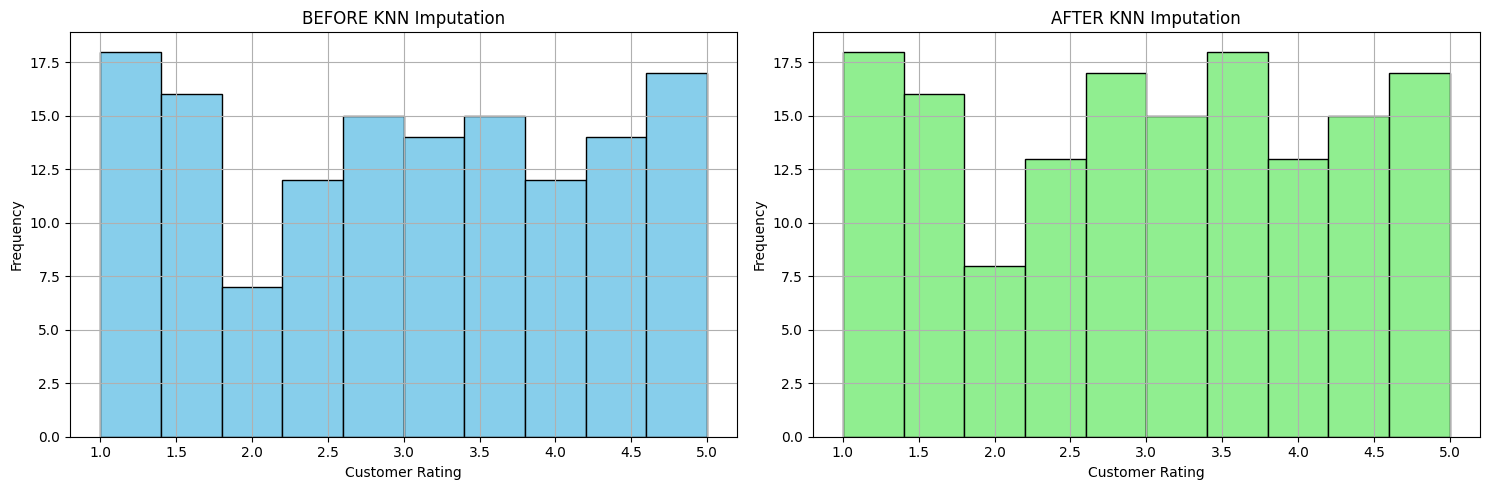

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Before
df['customer_rating'].hist(ax=axes[0], bins=10, color='skyblue', edgecolor='black')
axes[0].set_title("BEFORE KNN Imputation")
axes[0].set_xlabel("Customer Rating")
axes[0].set_ylabel("Frequency")

# After
df_knn['customer_rating'].hist(ax=axes[1], bins=10, color='lightgreen', edgecolor='black')
axes[1].set_title("AFTER KNN Imputation")
axes[1].set_xlabel("Customer Rating")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

### Data Augmentation Strategies

- Apply Random Noise to Numerical Transaction Values: to slightly perturb `purchase_amount` and `customer_rating` to simulate variation

In [ ]:
# Make a copy of the cleaned dataframe
df_augmented = df.copy()

# Set random seed for reproducibility
np.random.seed(42)

# Add random noise to 'purchase_amount'
noise_factor = 0.05
df_augmented['purchase_amount'] = df_augmented['purchase_amount'] * (
    1 + np.random.uniform(-noise_factor, noise_factor, df_augmented.shape[0])
)

# Add noise to 'customer_rating' (small noise within 0.1 range)
df_augmented['customer_rating'] = df_augmented['customer_rating'] + np.random.normal(0, 0.1, df_augmented.shape[0])

# Clip ratings to stay within valid range (e.g., 1 to 5)
df_augmented['customer_rating'] = df_augmented['customer_rating'].clip(1, 5)

# Preview
df_augmented.head()

,customer_id_legacy,transaction_id,purchase_amount,purchase_date,product_category,customer_rating
0,151,1001,402.881237,2024-01-01,Sports,2.280764
1,192,1002,346.963715,2024-01-02,Electronics,4.230155
2,114,1003,452.254132,2024-01-03,Electronics,2.096529
3,171,1004,258.525657,2024-01-04,Clothing,2.683132
4,160,1005,61.798519,2024-01-05,Clothing,1.414282


- Use SMOTE to Balance the Dataset: by creating more data points if the dataset is imbalanced on a categorical feature like `product_category`

SMOTE works only on numeric features, so convert categories to numbers first

In [ ]:
# Define the OneHotEncoder for 'product_category'
column_transformer = ColumnTransformer(
    transformers=[
        ('product_category', OneHotEncoder(), ['product_category'])  # Apply to 'product_category'
    ],
    remainder='passthrough'  # Keep the other columns as they are
)

# Apply the transformation to X
X_encoded = column_transformer.fit_transform(df_mean[['purchase_amount', 'customer_rating', 'product_category']])

# Convert the encoded data back to a DataFrame
X_encoded = pd.DataFrame(X_encoded, columns=column_transformer.get_feature_names_out())

# apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_encoded, y_encoded)

# Create a new DataFrame with the resampled data
df_smote = pd.DataFrame(X_resampled, columns=column_transformer.get_feature_names_out())
df_smote['product_category'] = le.inverse_transform(y_resampled)

# View the first 5 rows of the augmented data
df_smote.head()

,product_category__product_category_Books,product_category__product_category_Clothing,product_category__product_category_Electronics,product_category__product_category_Groceries,product_category__product_category_Sports,remainder__purchase_amount,remainder__customer_rating,product_category
0,0.0,0.0,0.0,0.0,1.0,408.0,2.3,Sports
1,0.0,0.0,1.0,0.0,0.0,332.0,4.2,Electronics
2,0.0,0.0,1.0,0.0,0.0,442.0,2.1,Electronics
3,0.0,1.0,0.0,0.0,0.0,256.0,2.8,Clothing
4,0.0,1.0,0.0,0.0,0.0,64.0,1.3,Clothing


In [ ]:
print(df_smote.columns)

Index(['remainder__purchase_amount', 'remainder__customer_rating',
       'product_category'],
      dtype='object')


### Feature Value Transformation

- apply log transformation to skewed data like `purchase_amount` and `customer_rating`

In [ ]:
df_smote['log_purchase_amount'] = np.log1p(df_smote['remainder__purchase_amount'])  # log1p is used to handle zeros
df_smote['log_customer_rating'] = np.log1p(df_smote['remainder__customer_rating'])  # log1p handles zero values

# View the first few rows to verify the log-transformed columns
df_smote[['remainder__purchase_amount', 'log_purchase_amount', 'remainder__customer_rating', 'log_customer_rating']].head()

,remainder__purchase_amount,log_purchase_amount,remainder__customer_rating,log_customer_rating
0,408.0,6.013715,2.3,1.193922
1,332.0,5.808142,4.2,1.648659
2,442.0,6.093570,2.1,1.131402
3,256.0,5.549076,2.8,1.335001
4,64.0,4.174387,1.3,0.832909


### Data Expansion

- Generate new synthetic transactions based on existing customer behaviors

In [ ]:
# Generate synthetic transactions by perturbing existing ones with random noise
def generate_synthetic_data(df, num_synthetic=100):
    # Randomly sample existing rows
    synthetic_data = df.sample(n=num_synthetic, replace=True)

    # Add slight random noise to the purchase amount and customer rating
    noise_purchase = np.random.normal(0, 0.1, size=synthetic_data.shape[0])
    noise_rating = np.random.normal(0, 0.1, size=synthetic_data.shape[0])

    # Add noise to the columns
    synthetic_data['purchase_amount'] += noise_purchase
    synthetic_data['customer_rating'] += noise_rating

    return synthetic_data

# Generate synthetic data - 100 new synthetic transactions
num_synthetic = 100
synthetic_df = generate_synthetic_data(df, num_synthetic)

# Combine the synthetic data with the original data
augmented_df = pd.concat([df, synthetic_df], ignore_index=True)

# Check the augmented data
print(augmented_df.head())

   customer_id_legacy  transaction_id  purchase_amount purchase_date  \
0                 151            1001            408.0    2024-01-01   
1                 192            1002            332.0    2024-01-02   
2                 114            1003            442.0    2024-01-03   
3                 171            1004            256.0    2024-01-04   
4                 160            1005             64.0    2024-01-05   

  product_category  customer_rating  
0           Sports              2.3  
1      Electronics              4.2  
2      Electronics              2.1  
3         Clothing              2.8  
4         Clothing              1.3  


### Export the Augmented Data

In [ ]:
# Export the augmented DataFrame to a CSV file
augmented_df.to_csv('data/customer_transactions_augmented.csv', index=False)

# Confirm the file has been saved
print("Augmented data saved as 'customer_transactions_augmented.csv'")

Augmented data saved as 'customer_transactions_augmented.csv'


# PART 2: Merging datasets

In [ ]:
#ignore warnings
warnings.filterwarnings('ignore')

Import the data

In [ ]:
path_mapping = "/content/drive/MyDrive/ALU/datasets/id_mapping.csv"
path_social_profiles = "/content/drive/MyDrive/ALU/datasets/customer_social_profiles.csv"
path_transactions_aug = "/content/drive/MyDrive/ALU/datasets/customer_transactions_augmented.csv"

mappings = pd.read_csv(path_mapping)
profiles = pd.read_csv(path_social_profiles)
transactions = pd.read_csv(path_transactions_aug)

Understand the csv shapes

In [ ]:
print("mapping shape")
print(mappings.shape)
print("social profiles shape")
print(profiles.shape)
print("transactions shape")
print(transactions.shape)

mapping shape
(155, 2)
social profiles shape
(155, 5)
transactions shape
(250, 6)


Checking for duplicates

In [ ]:

duplicate_legacy_ids = mappings[mappings.duplicated(subset=['customer_id_legacy'], keep=False)]
duplicate_new_ids = mappings[mappings.duplicated(subset=['customer_id_new'], keep=False)]

print("Duplicate legacy IDs:")
print(duplicate_legacy_ids.shape[0])
print("\nDuplicate new IDs:")
print(duplicate_new_ids.shape[0])

if not duplicate_legacy_ids.empty:
    print("\nSample duplicate legacy IDs:")
    display(duplicate_legacy_ids.head())

Duplicate legacy IDs:
125

Duplicate new IDs:
129

Sample duplicate legacy IDs:


,customer_id_legacy,customer_id_new
0,195,A105
2,192,A156
3,157,A168
4,166,A102
5,155,A100


Merge Transactions with ID mapping

In [ ]:
clean_mappings = mappings.drop_duplicates(subset=['customer_id_legacy'], keep='first')

merge_1 = pd.merge(transactions, clean_mappings, on="customer_id_legacy", how="left")

Merge with social profile using new customer IDs

In [ ]:
# Merge with social profile using new customer IDs
merge_2 = pd.merge(merge_1, profiles, on="customer_id_new", how="left")

In [ ]:
print(f"After second merge: {merge_2.shape}")
display(merge_2.head())

After second merge: (396, 11)


,customer_id_legacy,transaction_id,purchase_amount,purchase_date,product_category,customer_rating,customer_id_new,social_media_platform,engagement_score,purchase_interest_score,review_sentiment
0,151,1001,408.0,2024-01-01,Sports,2.3,A176,Facebook,70.0,3.3,Negative
1,192,1002,332.0,2024-01-02,Electronics,4.2,A156,Instagram,52.0,4.9,Positive
2,114,1003,442.0,2024-01-03,Electronics,2.1,A171,NaN,NaN,NaN,NaN
3,171,1004,256.0,2024-01-04,Clothing,2.8,NaN,NaN,NaN,NaN,NaN
4,160,1005,64.0,2024-01-05,Clothing,1.3,NaN,NaN,NaN,NaN,NaN


Handling Duplicates

In [ ]:
merge_2['purchase_date'] = pd.to_datetime(merge_2['purchase_date'])

reference_date = merge_2['purchase_date'].max() + pd.Timedelta(days=1)

# Calculate days since last purchase
merge_2['days_since_purchase'] = (reference_date - merge_2['purchase_date']).dt.days

Client Sentiment Anaylsis

In [ ]:
customer_aggs = merge_2.groupby('customer_id_legacy').agg(
    total_spent=('purchase_amount', 'sum'),
    avg_purchase=('purchase_amount', 'mean'),
    purchase_count=('transaction_id', 'count'),
    avg_rating=('customer_rating', 'mean'),
    first_purchase_date=('purchase_date', 'min'),  # Renamed to avoid confusion
    last_purchase_date=('purchase_date', 'max'),  # Renamed to avoid confusion
    avg_engagement=('engagement_score', 'mean'),
    avg_interest=('purchase_interest_score', 'mean')
).reset_index()

# Calculate days between first and last purchase (customer tenure)
customer_aggs['customer_tenure'] = (customer_aggs['last_purchase_date'] - customer_aggs['first_purchase_date']).dt.days
customer_aggs['customer_tenure'] = customer_aggs['customer_tenure'].fillna(0)

# Calculate purchase frequency (purchases per day of tenure)
customer_aggs['purchase_frequency'] = customer_aggs.apply(
    lambda x: x['purchase_count'] / (x['customer_tenure'] + 1), axis=1)

# Calculate monetary value (average purchase amount)
customer_aggs['monetary_value'] = customer_aggs['avg_purchase']

# Create customer engagement score
customer_aggs['engagement_score'] = (
    0.3 * customer_aggs['avg_engagement'].fillna(customer_aggs['avg_engagement'].mean()) / 100 +
    0.3 * customer_aggs['purchase_frequency'] / customer_aggs['purchase_frequency'].max() +
    0.4 * customer_aggs['monetary_value'] / customer_aggs['monetary_value'].max()
)

# Scale the engagement score from 0-100
customer_aggs['engagement_score'] = customer_aggs['engagement_score'] * 100
customer_aggs['engagement_score'] = customer_aggs['engagement_score'].clip(0, 100)

In [ ]:
# Sort data by customer and purchase date
merge_2_sorted = merge_2.sort_values(['customer_id_legacy', 'purchase_date'])

# Calculate rolling average of last 3 purchases (if available)
merge_2_sorted['rolling_avg_3'] = merge_2_sorted.groupby('customer_id_legacy')['purchase_amount'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean())

# Calculate month of purchase for time-based aggregation
merge_2_sorted['purchase_month'] = merge_2_sorted['purchase_date'].dt.to_period('M')

Method to create sentiment features

In [ ]:
def create_sentiment_features(df):
    # Filter for non-null sentiment
    sentiment_map = {'Positive': 1, 'Negative': -1, 'Neutral': 0}
    df['sentiment_score'] = df['review_sentiment'].map(sentiment_map).fillna(0)
    return df

# Apply sentiment feature creation
merge_2_processed = create_sentiment_features(merge_2_sorted)

# Calculate reference date for recency calculation
reference_date = merge_2['purchase_date'].max() + pd.Timedelta(days=1)

# Calculate days since last purchase (recency)
merge_2_processed['days_since_purchase'] = (reference_date - merge_2_processed['purchase_date']).dt.days

In [ ]:
final_dataset = pd.merge(merge_2_processed,
                         customer_aggs[['customer_id_legacy', 'engagement_score',
                                        'purchase_frequency', 'customer_tenure',
                                        'first_purchase_date']],
                         on='customer_id_legacy',
                         how='left',
                         suffixes=('', '_agg'))

final_dataset['days_since_first_purchase'] = (reference_date - final_dataset['first_purchase_date']).dt.days

# Create category
category_pivot = pd.pivot_table(merge_2,
                               values='purchase_amount',
                               index='customer_id_legacy',
                               columns='product_category',
                               aggfunc='sum').fillna(0)

## Merge category preferences with main dataset

In [ ]:
category_totals = category_pivot.sum(axis=1)
for column in category_pivot.columns:
    category_pivot[f'{column}_pct'] = category_pivot[column] / category_totals * 100

# Merge category preferences with main dataset
final_dataset = pd.merge(final_dataset,
                         category_pivot.reset_index(),
                         on='customer_id_legacy',
                         how='left')

# Select relevant columns
final_columns = [
    'customer_id_legacy', 'customer_id_new', 'purchase_amount', 'purchase_date',
    'product_category', 'customer_rating', 'social_media_platform', 'engagement_score',
    'purchase_interest_score', 'review_sentiment', 'sentiment_score', 'days_since_purchase',
    'rolling_avg_3', 'purchase_frequency', 'customer_tenure', 'days_since_first_purchase'
]

category_columns = [col for col in final_dataset.columns if '_pct' in col]
final_columns.extend(category_columns)

export the data

In [ ]:
export_columns = [col for col in final_columns if col in final_dataset.columns]
export_dataset = final_dataset[export_columns].copy()

# Export the dataset
export_dataset.to_csv('final_customer_data_group18.csv', index=False)
print("Final dataset exported successfully with shape:", export_dataset.shape)

Final dataset exported successfully with shape: (396, 21)


##PART 3: Data consistency & Quality checks

load the dataset

In [ ]:
# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/ALU/datasets/final_customer_data_group18.csv')

#still need to do the graph for before augmentation after the merge
before_data = pd.read_csv('/content/drive/MyDrive/ALU/datasets/customer_transactions.csv')

Duplicates check, unique values & validation

In [ ]:
# Check for duplicates
duplicate_count = data.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

# Check for unique categories in categorical columns
print("Unique values in product_category:")
print(data["product_category"].unique())

# Validate column relationships (e.g., purchase_amount > 0)
invalid_transactions = data[data["purchase_amount"] <= 0]
print(f"Number of invalid transactions: {len(invalid_transactions)}")


Number of duplicate rows: 2
Unique values in product_category:
['Clothing' 'Books' 'Groceries' 'Electronics' 'Sports']
Number of invalid transactions: 0


In [ ]:
# Drop duplicate rows
data_cleaned = data.drop_duplicates()
print("Duplicate rows removed!")

Duplicate rows removed!


Summary stats for numerical columns

In [ ]:
summary_stats = data_cleaned.describe()
print("Summary Statistics:")
print(summary_stats)

Summary Statistics:
       customer_id_legacy  purchase_amount  customer_rating  engagement_score  \
count          394.000000       394.000000       394.000000        394.000000   
mean           149.434010       280.203606         2.870686         58.875635   
std             31.894977       112.642120         1.401576         34.411627   
min            100.000000        51.000000         0.000000          0.000000   
25%            122.250000       192.000000         1.665363         52.000000   
50%            150.000000       271.025939         3.000000         73.000000   
75%            183.750000       386.929486         4.002077         84.500000   
max            199.000000       495.227576         5.000000         99.000000   

       purchase_interest_score  days_since_purchase  rolling_avg_3  \
count               394.000000           394.000000     394.000000   
mean                  2.511421            76.307107     278.192467   
std                   1.714493          

Visualise purchase_amounts before & after

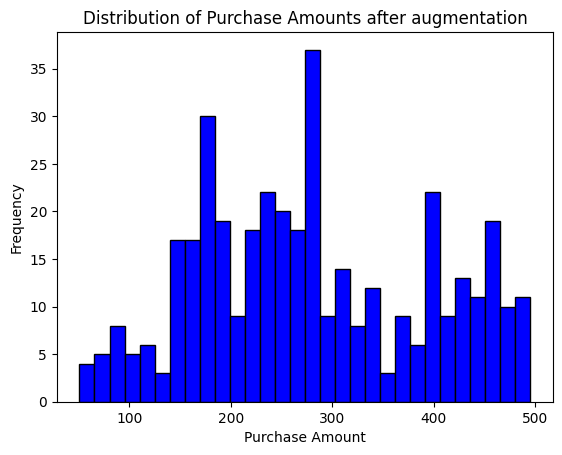

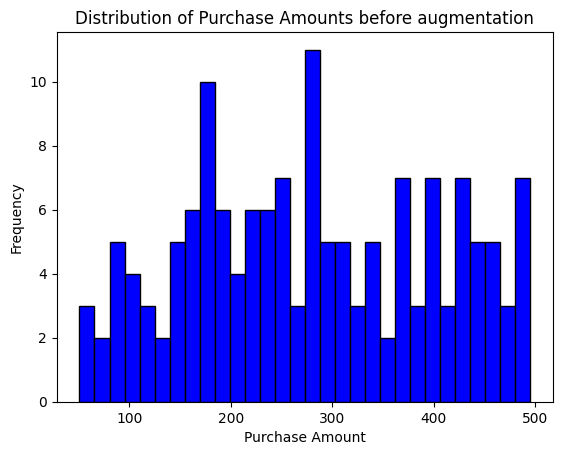

In [ ]:
import matplotlib.pyplot as plt

# Histogram for purchase_amount
plt.hist(data_cleaned["purchase_amount"], bins=30, edgecolor="black", color="blue")
plt.title("Distribution of Purchase Amounts after augmentation")
plt.xlabel("Purchase Amount")
plt.ylabel("Frequency")
plt.show()

#History for purchase amount before augmentation
plt.hist(before_data["purchase_amount"], bins=30, edgecolor="black", color="blue")
plt.title("Distribution of Purchase Amounts before augmentation")
plt.xlabel("Purchase Amount")
plt.ylabel("Frequency")
plt.show()

Visualize the correlation heat map

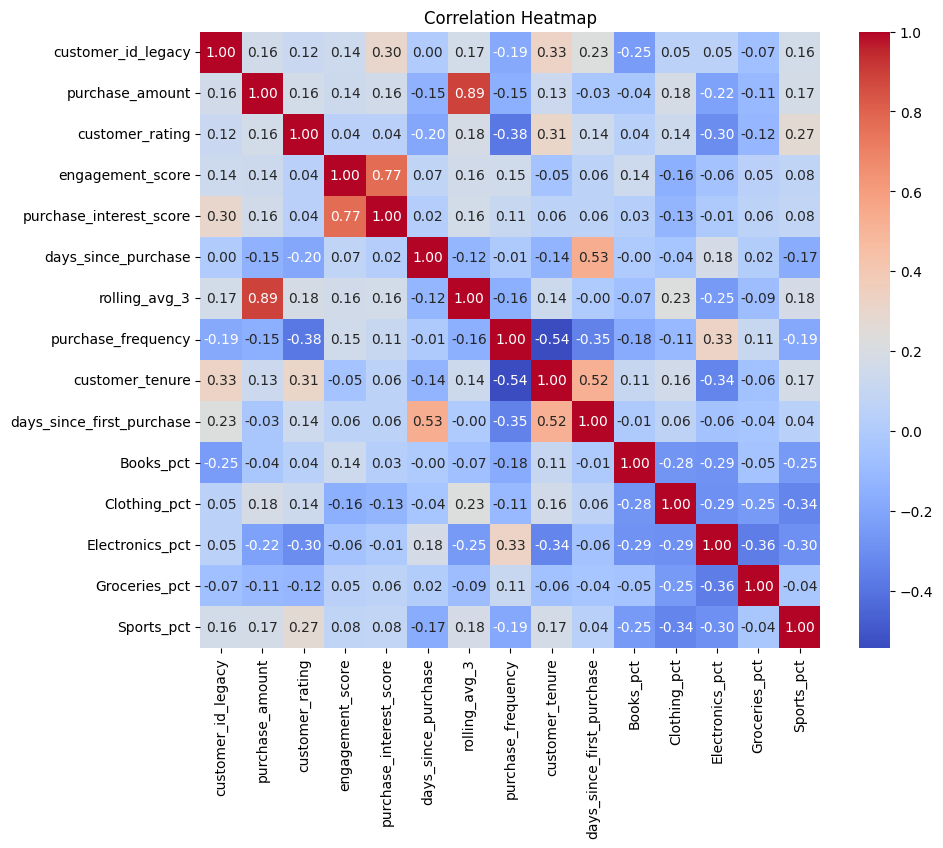

In [ ]:

# Select only numerical columns for correlation analysis
numerical_data = data_cleaned.select_dtypes(include=[np.number])

# Compute the correlation matrix
correlation_matrix = numerical_data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


Feature selection using SelectKBest

In [ ]:


# Define features (X) and target (y)
X = numerical_data.drop(columns=["purchase_amount"])  # Drop the target column
y = numerical_data["purchase_amount"]

# Initialize the SelectKBest feature selector
selector = SelectKBest(score_func=f_regression, k=10)  # Choose top 10 features

# Fit the selector to the data
X_new = selector.fit_transform(X, y)

# Get the names of selected features
selected_features = X.columns[selector.get_support()]
print("Top 10 Features Selected:")
print(selected_features)


Top 10 Features Selected:
Index(['customer_id_legacy', 'customer_rating', 'engagement_score',
       'purchase_interest_score', 'days_since_purchase', 'rolling_avg_3',
       'purchase_frequency', 'Clothing_pct', 'Electronics_pct', 'Sports_pct'],
      dtype='object')


## Save the cleaned and processed dataset

In [ ]:
X_selected = X[selected_features]
X_selected["purchase_amount"] = y

# Save the final dataset with top 10 features and target variable
X_selected.to_csv("final_dataset_ready_group18.csv", index=False)

print("Dataset with top 10 features saved successfully as 'final_dataset_top_10_features.csv'")


Dataset with top 10 features saved successfully as 'final_dataset_top_10_features.csv'


<ipython-input-12-808a0ee252e1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_selected["purchase_amount"] = y


#Bonus Challenge

using Random Forest

In [13]:
X_selected.head(10)

,customer_id_legacy,customer_rating,engagement_score,purchase_interest_score,days_since_purchase,rolling_avg_3,purchase_frequency,Clothing_pct,Electronics_pct,Sports_pct,purchase_amount
0,100,4.000000,0.0,0.0,38,172.000000,0.171429,30.774355,0.0,0.0,172.000000
1,100,3.912603,0.0,0.0,38,172.013782,0.171429,30.774355,0.0,0.0,172.027564
2,100,3.933160,0.0,0.0,38,172.019266,0.171429,30.774355,0.0,0.0,172.030235
3,100,4.600000,0.0,0.0,4,243.685933,0.171429,30.774355,0.0,0.0,387.000000
4,100,4.489875,0.0,0.0,4,315.321271,0.171429,30.774355,0.0,0.0,386.933577
5,100,4.554189,0.0,0.0,4,386.950263,0.171429,30.774355,0.0,0.0,386.917211
6,101,2.100000,78.0,1.1,134,271.000000,0.526316,0.000000,0.0,0.0,271.000000
7,101,2.100000,89.0,2.4,134,271.000000,0.526316,0.000000,0.0,0.0,271.000000
8,101,2.100000,81.0,4.6,134,271.000000,0.526316,0.000000,0.0,0.0,271.000000
9,101,2.100000,83.0,1.2,134,271.000000,0.526316,0.000000,0.0,0.0,271.000000


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['customer_id_legacy'].plot(kind='hist', bins=20, title='customer_id_legacy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['customer_rating'].plot(kind='hist', bins=20, title='customer_rating')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['engagement_score'].plot(kind='hist', bins=20, title='engagement_score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='index', y='customer_id_legacy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='customer_id_legacy', y='customer_rating', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='customer_rating', y='engagement_score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='engagement_score', y='purchase_interest_score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['customer_rating']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('customer_rating')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['engagement_score']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('engagement_score')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['purchase_interest_score']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('purchase_interest_score')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['days_since_purchase']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('days_since_purchase')

from matplotlib import pyplot as plt
_df_12['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['customer_id_legacy'].plot(kind='line', figsize=(8, 4), title='customer_id_legacy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['customer_rating'].plot(kind='line', figsize=(8, 4), title='customer_rating')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['engagement_score'].plot(kind='line', figsize=(8, 4), title='engagement_score')
plt.gca().spines[['top', 'right']].set_visible(False)

In [33]:
features = ['customer_id_legacy', 'customer_rating', 'engagement_score',
       'purchase_interest_score', 'days_since_purchase', 'rolling_avg_3',
       'purchase_frequency', 'Clothing_pct', 'Electronics_pct', 'Sports_pct']
target = 'purchase_amount'
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.2f}")

# Predict for a specific cell and compare with actual value
sample_index = 0  # Change this to the desired row index
sample_data = X_test.iloc[[sample_index]]
predicted_value = model.predict(sample_data)[0]
actual_value = y_test.iloc[sample_index]
print(f"Predicted purchase amount: {predicted_value:.2f}, Actual purchase amount: {actual_value:.2f}")


Mean Absolute Error: 40.12
Predicted purchase amount: 431.04, Actual purchase amount: 434.00


More Predictions

In [29]:
# Predict for an example
sample_index = 19
sample_data = X_test.iloc[[sample_index]]
predicted_value = model.predict(sample_data)[0]
actual_value = y_test.iloc[sample_index]
print(f"Predicted purchase amount: {predicted_value:.2f}, Actual purchase amount: {actual_value:.2f}")

Predicted purchase amount: 470.40, Actual purchase amount: 469.04


In [28]:
# Predict for an example
sample_index = 78
sample_data = X_test.iloc[[sample_index]]
predicted_value = model.predict(sample_data)[0]
actual_value = y_test.iloc[sample_index]
print(f"Predicted purchase amount: {predicted_value:.2f}, Actual purchase amount: {actual_value:.2f}")

Predicted purchase amount: 192.04, Actual purchase amount: 192.00
